# Analyse du data

In [1]:
# Imports PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("BTC_Silver") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/20 14:24:53 WARN Utils: Your hostname, DESKTOP-3IKPR1U, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/20 14:24:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/20 14:25:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Lecture du fichier Parquet Bronze
bronze_path = "/mnt/c/Users/hp/desktop/BTC-End2End-Platform/ml/data/bronze/btc_minute_data.parquet"
df_bronze = spark.read.parquet(bronze_path)

# Afficher un aperçu
df_bronze.show(5)


+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+------+
|          open_time|    open|    high|     low|   close| volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|
+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+------+
|2026-01-19 09:53:00|93046.35|93046.35|92997.65| 93001.8|9.10532|2026-01-19 09:53:...|    847027.2616431|            2024|              2.08878|        194272.7849138|     0|
|2026-01-19 09:54:00| 93001.8|93022.23|93001.79|93014.94|5.62556|2026-01-19 09:54:...|    523245.8306426|            1064|              3.42885|        318907.7899883|     0|
|2026-01-19 09:55:00|93014.95|93042.27|93014.95|93022.36|3.74306|2026-01-19 09:55:...|    348227.1952126|            1863|   

In [3]:
df_bronze.printSchema()

root
 |-- open_time: timestamp_ntz (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- close_time: timestamp_ntz (nullable = true)
 |-- quote_asset_volume: double (nullable = true)
 |-- number_of_trades: long (nullable = true)
 |-- taker_buy_base_volume: double (nullable = true)
 |-- taker_buy_quote_volume: double (nullable = true)
 |-- ignore: string (nullable = true)



In [4]:
df_bronze.columns

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_volume',
 'taker_buy_quote_volume',
 'ignore']

In [5]:
df_bronze.describe().show()

26/01/20 14:25:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------+----------------------+------+
|summary|              open|              high|               low|             close|           volume|quote_asset_volume|  number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------+----------------------+------+
|  count|               600|               600|               600|               600|              600|               600|               600|                  600|                   600|   600|
|   mean| 93070.08556666668| 93084.20378333335| 93055.98494999995|  93070.1422166667|5.902528833333327| 549296.6430280326|1694.1466666666668|    2.621530233333333|     243988.0310935778|   0.0|
| stddev|119.90986944226844|11

In [6]:
from pyspark.sql.functions import col, sum as spark_sum, when
df_bronze.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
      for c in df_bronze.columns
      ]).show()

+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+
|open_time|open|high|low|close|volume|close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+
|        0|   0|   0|  0|    0|     0|         0|                 0|               0|                    0|                     0|     0|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+



In [7]:
print("Nombres des lingne:", df_bronze.count())

Nombres des lingne: 600


In [8]:
uniques_lignes = df_bronze.dropDuplicates().count()
print(f"Nombre de lignes uniques :{uniques_lignes}")

Nombre de lignes uniques :600


In [9]:
# decaler la colonne close de 10 lignes

window = Window.orderBy("open_time")

df_bronze = df_bronze.withColumn("close_t_plus_10", F.lead("close", 10).over(window))


In [10]:
# Calcule du return 
window = Window.orderBy("open_time")

df_bronze = df_bronze.withColumn(
    "return_1m",
    (F.col("close") - F.lag("close", 1).over(window)) / F.lag("close", 1).over(window)
)

df_bronze.select("open_time", "close", "return_1m").show(5)


26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+--------------------+
|          open_time|   close|           return_1m|
+-------------------+--------+--------------------+
|2026-01-19 09:53:00| 93001.8|                NULL|
|2026-01-19 09:54:00|93014.94|1.412875879821618...|
|2026-01-19 09:55:00|93022.36| 7.97721312296525E-5|
|2026-01-19 09:56:00|93019.77|-2.78427681258195...|
|2026-01-19 09:57:00|93016.23|-3.80564260695134...|
+-------------------+--------+--------------------+
only showing top 5 rows


In [11]:
#  la moyenne des prix de clôture sur les 5 et 10 dernières minutes 

window_5 = Window.orderBy("open_time").rowsBetween(-4, 0)
window_10 = Window.orderBy("open_time").rowsBetween(-9, 0)
  
df_bronze = df_bronze.withColumn("MA_5", F.avg("close").over(window_5))
df_bronze = df_bronze.withColumn("MA_10", F.avg("close").over(window_10))

In [12]:
# Volume et intensité de trading

df_bronze = df_bronze.withColumn("taker_ratio", 
      F.col("taker_buy_base_volume") / F.col("volume"))

In [13]:
df_bronze.show()


26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:25:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+---------------+--------------------+-----------------+-----------------+--------------------+
|          open_time|    open|    high|     low|   close|  volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|close_t_plus_10|           return_1m|             MA_5|            MA_10|         taker_ratio|
+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+---------------+--------------------+-----------------+-----------------+--------------------+
|2026-01-19 09:53:00|93046.35|93046.35|92997.65| 93001.8| 9.10532|2026-01-19 09:53:...|    847027.2616431|            2024|              2.08878|        194272.7849138|     0|       92965.51

In [17]:
df_bronze.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
      for c in df_bronze.columns
      ]).show()

26/01/20 14:26:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:26:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:26:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 14:26:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+---------------+---------+----+-----+-----------+
|open_time|open|high|low|close|volume|close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|close_t_plus_10|return_1m|MA_5|MA_10|taker_ratio|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+---------------+---------+----+-----+-----------+
|        0|   0|   0|  0|    0|     0|         0|                 0|               0|                    0|                     0|     0|             10|        1|   0|    0|          0|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+------+---------------+---------+----+-----+-----------+



In [18]:
df_bronze.dropna().show()

26/01/20 15:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:27:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+---------------+--------------------+-----------------+-----------------+--------------------+
|          open_time|    open|    high|     low|   close|  volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|close_t_plus_10|           return_1m|             MA_5|            MA_10|         taker_ratio|
+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+---------------+--------------------+-----------------+-----------------+--------------------+
|2026-01-19 09:54:00| 93001.8|93022.23|93001.79|93014.94| 5.62556|2026-01-19 09:54:...|    523245.8306426|            1064|              3.42885|        318907.7899883|     0|       92975.79

In [19]:
uniques_lignes = df_bronze.dropDuplicates().count()
print(f"Nombre de lignes uniques :{uniques_lignes}")

26/01/20 15:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Nombre de lignes uniques :600


In [23]:
from pyspark.sql import functions as F

# Calculer les quartiles et l'IQR
quantiles = df_bronze.select(
    F.expr('percentile_approx(close_t_plus_10, 0.25)').alias('Q1'),
    F.expr('percentile_approx(close_t_plus_10, 0.75)').alias('Q3')
).collect()[0]

Q1 = quantiles['Q1']
Q3 = quantiles['Q3']
IQR = Q3 - Q1

# Définir les bornes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Bornes: [{lower_bound}, {upper_bound}]")

# Détecter les outliers
df_with_outliers = df_bronze.withColumn(
    'is_outlier',
    F.when(
        (F.col('close_t_plus_10') < lower_bound) | (F.col('close_t_plus_10') > upper_bound),
        True
    ).otherwise(False)
)

# Compter les outliers
outlier_count = df_with_outliers.filter(F.col('is_outlier') == True).count()
print(f"Nombre d'outliers: {outlier_count}")

# Afficher les outliers
df_with_outliers.filter(F.col('is_outlier') == True).show()

26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Q1: 92997.23, Q3: 93146.1, IQR: 148.8700000000099
Bornes: [92773.92499999999, 93369.40500000003]


26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Nombre d'outliers: 8


26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 15:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+---------------+--------------------+-----------------+-----------------+--------------------+----------+
|          open_time|    open|    high|     low|   close|  volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|ignore|close_t_plus_10|           return_1m|             MA_5|            MA_10|         taker_ratio|is_outlier|
+-------------------+--------+--------+--------+--------+--------+--------------------+------------------+----------------+---------------------+----------------------+------+---------------+--------------------+-----------------+-----------------+--------------------+----------+
|2026-01-19 14:26:00|92813.52|92842.91|92813.51|92838.05| 4.28239|2026-01-19 14:26:...|    397495.9354988|            1525|              3.20924|        2978

In [27]:
df_bronze.drop("ignore")
df_bronze.columns

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_volume',
 'taker_buy_quote_volume',
 'ignore',
 'close_t_plus_10',
 'return_1m',
 'MA_5',
 'MA_10',
 'taker_ratio']

# Visualisation


26/01/20 16:00:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:00:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:00:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:00:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:00:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


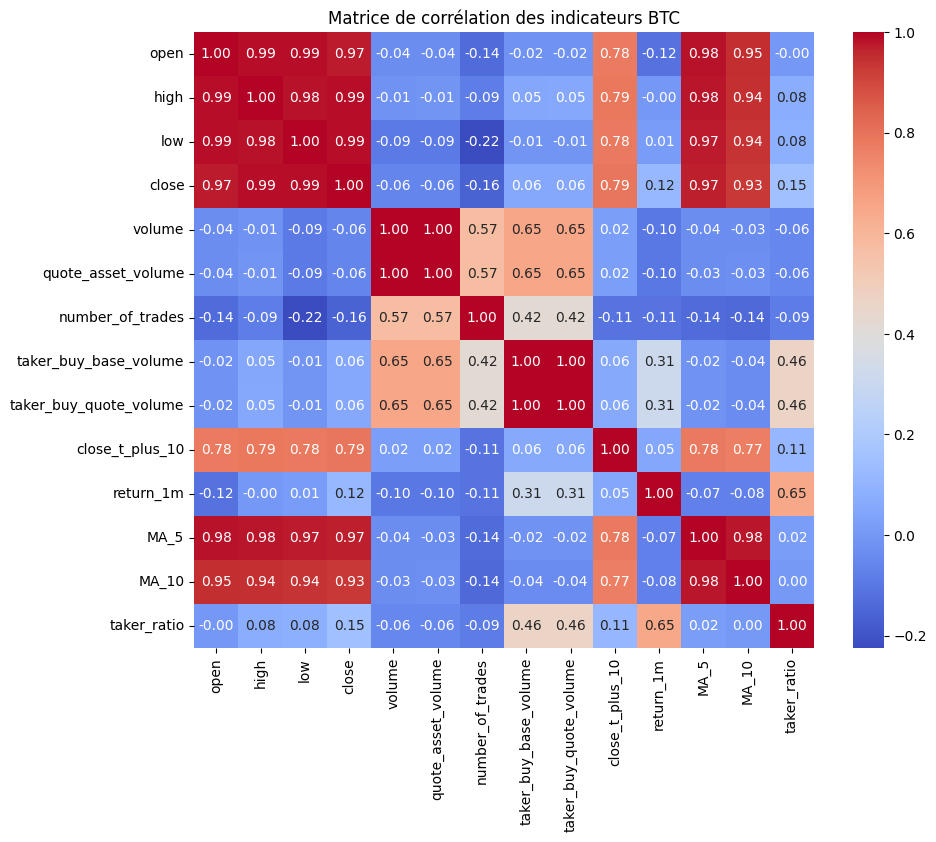

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des colonnes numériques pour la corrélation
cols_to_corr = [
 'open',
 'high',
 'low',
 'close',
 'volume',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_volume',
 'taker_buy_quote_volume',
 'close_t_plus_10',
 'return_1m',
 'MA_5',
 'MA_10',
 'taker_ratio'
 ]

pdf = df_bronze.select(cols_to_corr).toPandas()

# Affichage de la matrice
plt.figure(figsize=(10, 8))
sns.heatmap(pdf.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des indicateurs BTC")
plt.show()

In [29]:
df_silver = df_bronze.drop(
 'volume',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_volume',
 'taker_buy_quote_volume',
 'return_1m',
 'taker_ratio'
 )
df_silver.show()

26/01/20 16:04:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:04:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:04:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:04:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:04:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+--------+--------+--------+--------+--------------------+------+---------------+-----------------+-----------------+
|          open_time|    open|    high|     low|   close|          close_time|ignore|close_t_plus_10|             MA_5|            MA_10|
+-------------------+--------+--------+--------+--------+--------------------+------+---------------+-----------------+-----------------+
|2026-01-19 09:53:00|93046.35|93046.35|92997.65| 93001.8|2026-01-19 09:53:...|     0|       92965.51|          93001.8|          93001.8|
|2026-01-19 09:54:00| 93001.8|93022.23|93001.79|93014.94|2026-01-19 09:54:...|     0|       92975.79|         93008.37|         93008.37|
|2026-01-19 09:55:00|93014.95|93042.27|93014.95|93022.36|2026-01-19 09:55:...|     0|       92965.51|93013.03333333333|93013.03333333333|
|2026-01-19 09:56:00|93022.36|93042.25|93019.76|93019.77|2026-01-19 09:56:...|     0|        92900.0|       93014.7175|       93014.7175|
|2026-01-19 09:57:00|93019.77|9301

In [31]:
df_bronze.coalesce(1)\
    .write.mode("overwrite")\
    .parquet("/mnt/c/Users/hp/desktop/BTC-End2End-Platform/ml/data/silver/silver_dataset")


26/01/20 16:05:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:05:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:05:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:05:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/20 16:05:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
